Homework 4

CS 588 Intro to Big Data Fundamentals

October 28, 2020

Paul Abers

First, let's load in all neccessary modules and load in our iris and indian datasets.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.colors import CSS4_COLORS as mcolors
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.io import loadmat
from scipy.cluster import hierarchy
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.setrecursionlimit(10000)

In [4]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
#convert_species = np.vectorize(lambda x : "setosa" if x==0 else ("versicolor" if x==1 else "virginica"))
iris_unnamed = iris_df.copy(deep=True)
#iris_df["target"] = convert_species(iris.target)
iris_unnamed["target"] = iris.target

In [5]:
indian = loadmat(os.path.join(os.getcwd(), "indianR.mat"))
data = np.array(indian["X"]).T
targets = np.array(indian["gth"])[0]
indian_df = pd.DataFrame(data=data)
indian_df["target"] = targets
indexDrop = indian_df[indian_df["target"] == 0].index
indian_df.drop(indexDrop, inplace=True)
indian_df.reset_index(inplace=True)

Question 1)

a)

With both the iris and indian datasets, loop over the different cluster sizes and collect the cost for each number of clusters. Then plot cost vs clusters for an elbow method plot.

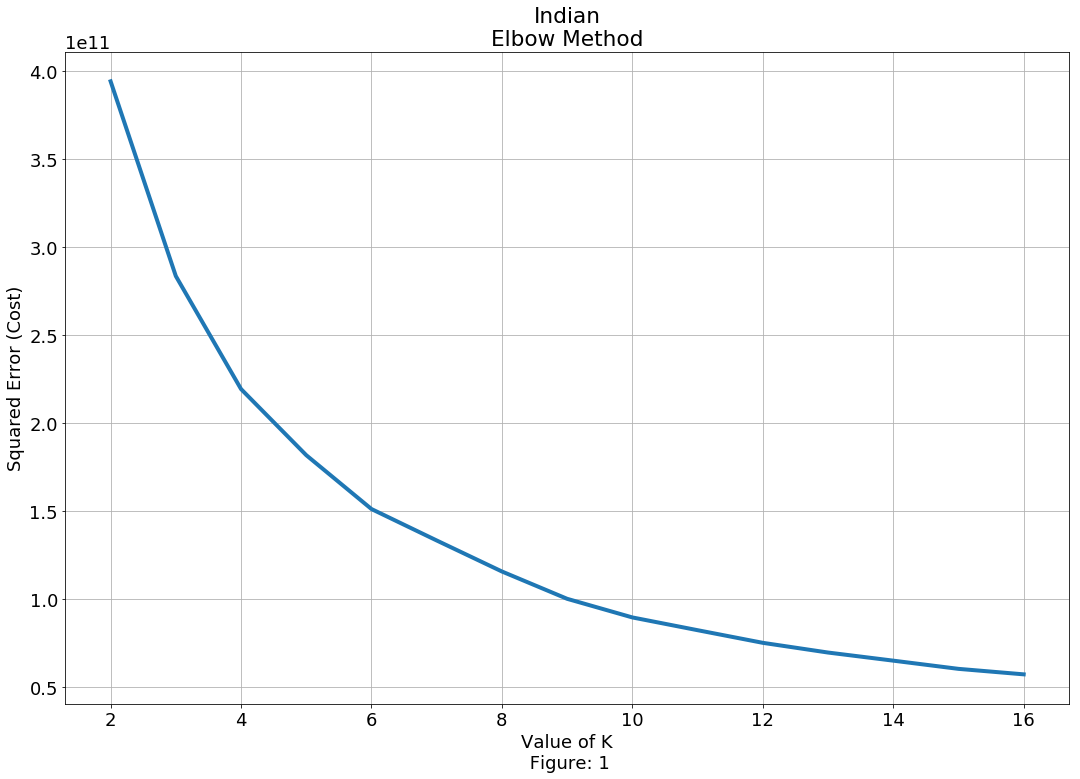

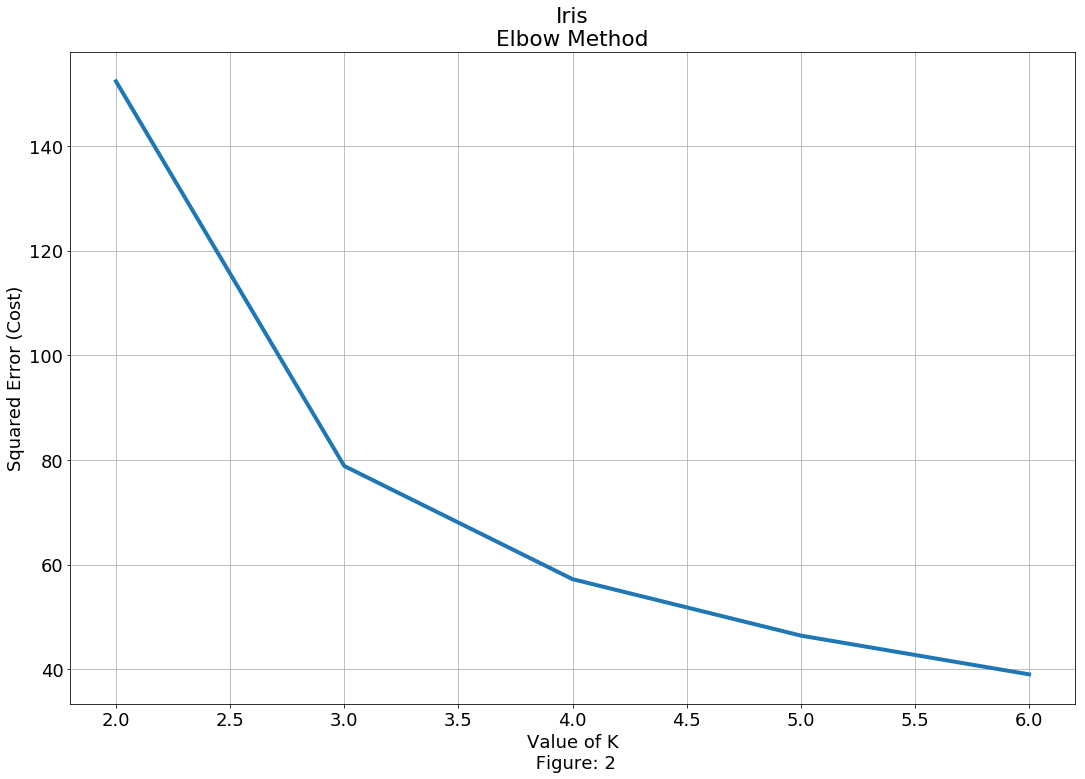

In [9]:
cost = {}
figure_count = 1
for name, data, iterable in [("indian", indian_df, range(2,17)), ("iris", iris_unnamed, range(2,7))]:
    cost[name] = []
    x = data.iloc[:, :-1]
    for num_clusters in iterable:
        km = KMeans(n_clusters=num_clusters, max_iter=500)
        km.fit(x)
        cost[name].append(km.inertia_)
    plt.figure(figsize=(18,12))
    plt.rcParams.update({'font.size': 18})
    plt.title(f"{name[0].upper()}{name[1:]}\nElbow Method")
    plt.xlabel(f"Value of K\n Figure: {figure_count}")
    plt.ylabel("Squared Error (Cost)")
    plt.plot(iterable, cost[name], linewidth=4)
    plt.grid()
    plt.show()
    figure_count += 1

b)

Based on the two elbow method plots above, it appears that the number of clusters for the iris and indian datasets are 4 and 8 respectively. These points are chosen because it appears to be the "elbow" of the plot. That is, before this point the cost is decreasing and after the continued decreasing of the cost sees diminishing returns. The exact point for the indian elbow is a little fluid and choices from 6 to 10 all seem like viable choices. Further testing could be used to try and determine the correct amount of clusters for the dataset. For the iris datset, even though 4 seems like number of clusters to choose, 3 also looks to be a good choice. Further investigation for the number of clusters from 2-4 would be advised to get a final determination for the correct amount of clusters to choose for the iris dataset.

Question 2)

a)

First, lets add the necessary functions for PCA and LDA (as taken from HW 3)

In [10]:
def scale(df, scaler="MinMax"):
    """Scale the dataframe using the scaler specified and return the newly scaled dataframe
    """
    inputs = df.iloc[:, :-1].to_numpy()
    if scaler == "MinMax":
        scale = MinMaxScaler()
    elif scaler == "Standard":
        scale = StandardScaler()
    else:
        raise ValueError(f"Unsupported scaler {scaler}")
    scale.fit(inputs.astype(float))
    inputs = scale.transform(inputs)
    
    scaled_df = pd.DataFrame(data=inputs)

    scaled_df["target"] = df["target"]
    
    return scaled_df

In [11]:
def fit_pca(df, **kwargs):
    """Apply and return the prinicpal component fit for the dataframe
    """
    n_components = kwargs.get("n_components", len(df.columns)-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    
    pca = PCA(n_components=n_components)
    pc = pca.fit(inputs)
    
    return pc

In [12]:
def transform_pca(df, pc):
    """Use the given principal component fit to transform the dataframe and return the transformed dataframe
    """
    inputs = df.iloc[:, :-1].to_numpy()
    transformed_df = pd.DataFrame(data=pc.transform(inputs))
    transformed_df.columns = [*map(lambda y : f"PC-{y}", list(range(1, pc.n_components + 1)))] 
    transformed_df["target"] = df["target"]
    return transformed_df

In [13]:
def perform_pca(df, **kwargs):
    """Single function call to scale, fit and transform the data with pca
    """
    df_scaled = scale(df)
    pc = fit_pca(df_scaled, **kwargs)
    df_pca = transform_pca(df_scaled, pc)
    
    return df_pca

In [14]:
def perform_lda(df, **kwargs):
    """Perform linear discriminant analysis on the data and returned the transformed data
    """
    n_components = kwargs.get("n_components", len(np.unique(df["target"].values))-1)
    
    inputs = df.iloc[:, :-1].to_numpy()
    targets = np.array(df["target"].values)

    lda = LinearDiscriminantAnalysis(n_components=n_components)
    transform_df = pd.DataFrame(data=lda.fit(inputs, targets).transform(inputs))
    transform_df.columns = [f"LD-{i+1}" for i in range(len(transform_df.columns))]
    transform_df["target"] = df["target"]
    
    return transform_df

First, lets setup all the input parameters.

In [15]:
num_clusters = {"indian": 8,
            "iris": 4}
dfs = {"iris_PCA_2": perform_pca(iris_unnamed, n_components=2),
      "iris_LDA_2": perform_lda(iris_unnamed, n_components=2),
      "iris_None_None": iris_unnamed,
      "indian_PCA_2": perform_pca(indian_df, n_components=2),
      "indian_LDA_2": perform_lda(indian_df, n_components=2),
      "indian_None_None": indian_df
    }
clustering_metrics = ["cosine", "euclidean"]
clustering = ["KMeans", "Hierachy"]

Now, lets setup the necessary functions for running and plotting the clustering techniques.

In [16]:
def run_cluster(data, num_clusters, clusterer, metric):
    x = data.iloc[:, :-1]
    if clusterer == "KMeans":
        cluster = KMeans(n_clusters=num_clusters, n_jobs=3, random_state=42)
        cluster.fit(x)
    else:
        cluster = hierarchy.linkage(x, metric=metric)
    return cluster

In [17]:
def plot_cluster(cluster, clusterer, data, name, **kwargs):
    if clusterer == "KMeans":
        plot_kmeans(cluster, data, name, **kwargs)
    else:
        plot_hierarchy(cluster, data, name, **kwargs)
    return

In [18]:
def plot_kmeans(cluster, data, name, **kwargs):
    def get_title(name, num_clusters, dim_red, metric):
        title = f"KMeans Clustering\nDataset: {name} - Number of Clusters: {num_clusters}\n"
        title += f"Dimensionality Reduction: {dim_red}"
        return title
    
    xlabel = {"PCA_iris":"PCA - 1",
              "LDA_iris":"LDA - 1",
              "PCA_indian":"PCA - 1",
              "LDA_indian":"LDA - 1",
              "None_iris":"Petal Length",
              "None_indian":"Band - 0"
             }
    
    ylabel = {"PCA_iris":"PCA - 2",
              "LDA_iris":"LDA - 2",
              "PCA_indian":"PCA - 2",
              "LDA_indian":"LDA - 2",
              "None_iris":"Petal Width",
              "None_indian":"Band - 1"
             }

    xcol = {"PCA_iris":"PC-1",
            "LDA_iris":"LD-1",
            "PCA_indian":"PC-1",
            "LDA_indian":"LD-1",
            "None_iris":"petal length (cm)",
            "None_indian":0
            }
    
    ycol = {"PCA_iris":"PC-2",
            "LDA_iris":"LD-2",
            "PCA_indian":"PC-2",
            "LDA_indian":"LD-2",
            "None_iris":"petal width (cm)",
            "None_indian":1
            }

                
    def get_kmeans_output(km, data):
        centroids = pd.DataFrame(km.cluster_centers_, columns=data.columns[:-1])
        labels = np.array(km.labels_)
        return centroids, labels
    
    num_clusters = kwargs.get("num_clusters", "")
    dim_red = kwargs.get("dim_red", "")
    metric = kwargs.get("metric", "")
    figure_count = kwargs.get("figure_count", "1")
    
    title = get_title(name, num_clusters, dim_red, metric)
    xlabel, ylabel = xlabel[str(dim_red)+"_"+name], ylabel[str(dim_red)+"_"+name]
    xcol, ycol = xcol[str(dim_red)+"_"+name], ycol[str(dim_red)+"_"+name]
    centroids, labels = get_kmeans_output(cluster, data)
    
    colors = np.array([mcolors["maroon"], mcolors["gold"], mcolors["cyan"], mcolors["lawngreen"],
                       mcolors["darkgreen"], mcolors["dodgerblue"], mcolors["slategrey"], mcolors["royalblue"],
                       mcolors["rebeccapurple"], mcolors["violet"], mcolors["deeppink"], mcolors["coral"], 
                       mcolors["darkgoldenrod"], mcolors["yellow"], mcolors["indigo"], mcolors["lightseagreen"],
                       mcolors["thistle"]])
    
    fig, ax = plt.subplots(2, figsize=(18,12))
    plt.rcParams.update({'font.size': 18})
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].grid(True)
    ax[1].set_xlabel(xlabel + f"\nFigure: {figure_count}")
    ax[1].set_ylabel(ylabel)
    ax[1].grid(True)
    ax[0].set_title(title+"\nTrue Class Labels")
    ax[1].set_title("Predicted Cluster Labels")
    ax[0].scatter(data[xcol], data[ycol], c=colors[data.loc[:, "target"].to_numpy()], s=50, alpha=0.5)
    ax[0].scatter(centroids[xcol], centroids[ycol], c="k", s=150, alpha=0.7)
    ax[1].scatter(data[xcol], data[ycol], c=colors[labels], label=labels, s=50, alpha=0.5)
    ax[1].scatter(centroids[xcol], centroids[ycol], c="k", s=150, alpha=0.7)
    fig.tight_layout()
    return

In [19]:
def plot_hierarchy(cluster, data, name, **kwargs):
    def get_title(name, num_clusters, dim_red, metric):
        title = f"Hierarchical Clustering\nDataset: {name}\n"
        title += f"Dimensionality Reduction: {dim_red}"
        return title
    
    dim_red = kwargs.get("dim_red", "")
    metric = kwargs.get("metric", "  ")
    figure_count = kwargs.get("figure_count", "1")
    
    title = get_title(name, num_clusters, dim_red, metric)
    
    fig, ax = plt.subplots(figsize=(18,12))
    plt.rcParams.update({'font.size': 18})
    ax.set_xlabel("Data Points" + f"\nFigure: {figure_count}")
    ax.set_ylabel(f"{metric[0].upper()}{metric[1:]}")
    ax.set_title(title)
    dn = hierarchy.dendrogram(cluster, leaf_font_size=12, ax=ax)
    
    return

In [20]:
def smallify_df(df, factor1, factor2):
    indices = []
    targets = np.unique(df.loc[:, "target"].to_numpy())
    for tgt in targets:
        idx = list(df.loc[df["target"] == tgt].index)
        if len(idx) > 500:
            sub_idx = idx[:len(idx)//factor2]
        else:
            sub_idx = idx[:len(idx)//factor1]
        indices += sub_idx
    return df.loc[indices, :]

Now, loop over the different setups and run the clustering techniques

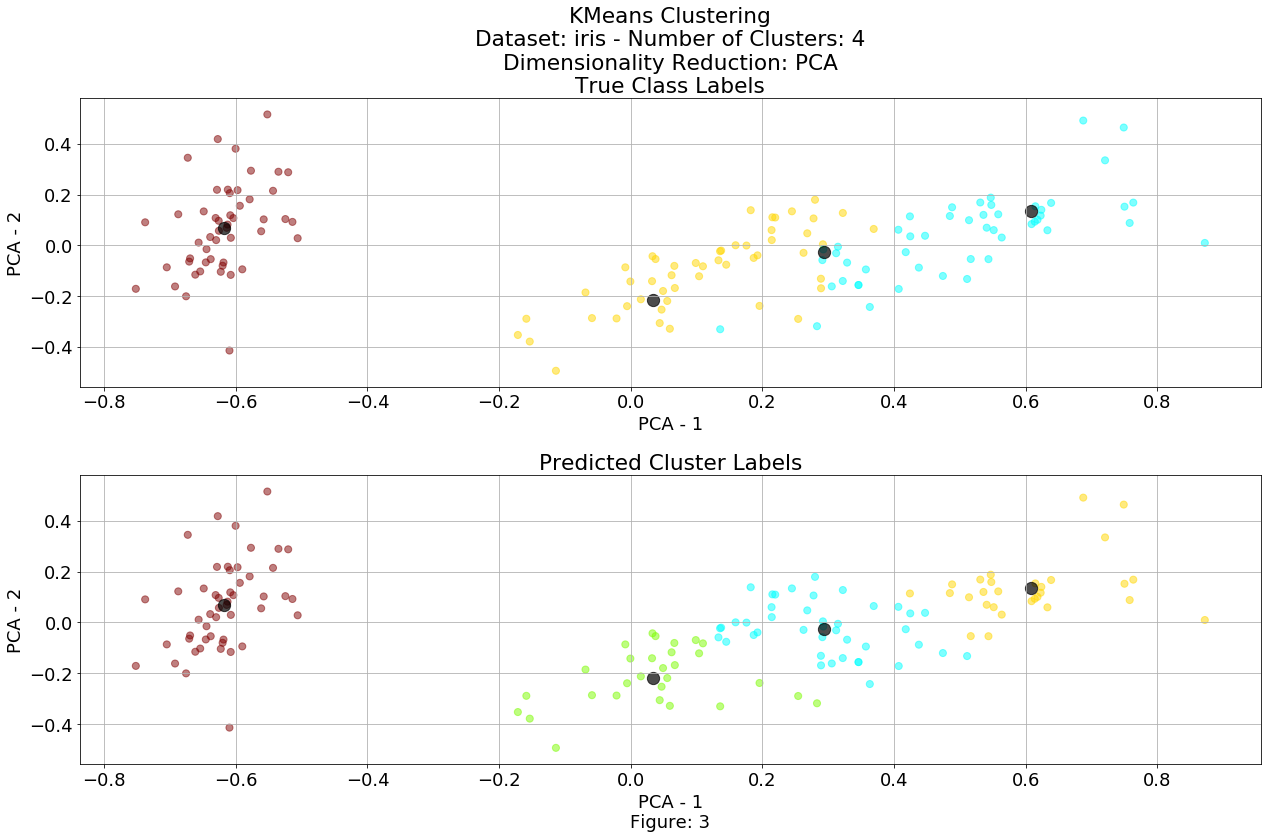

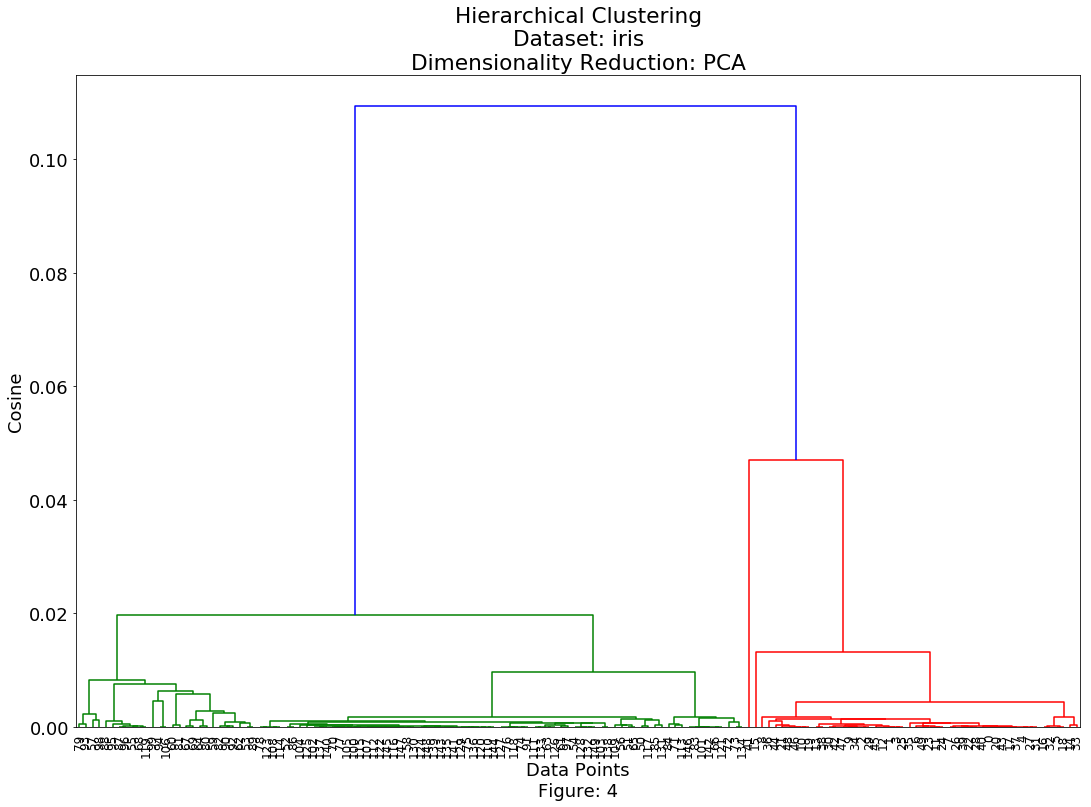

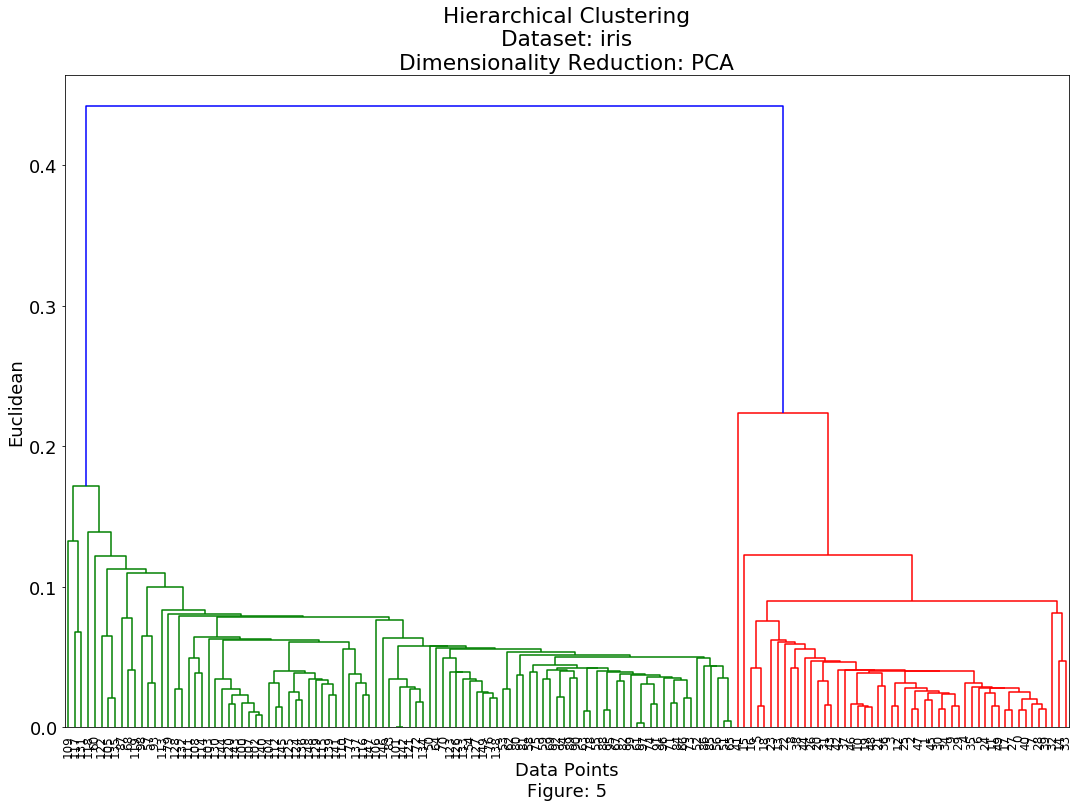

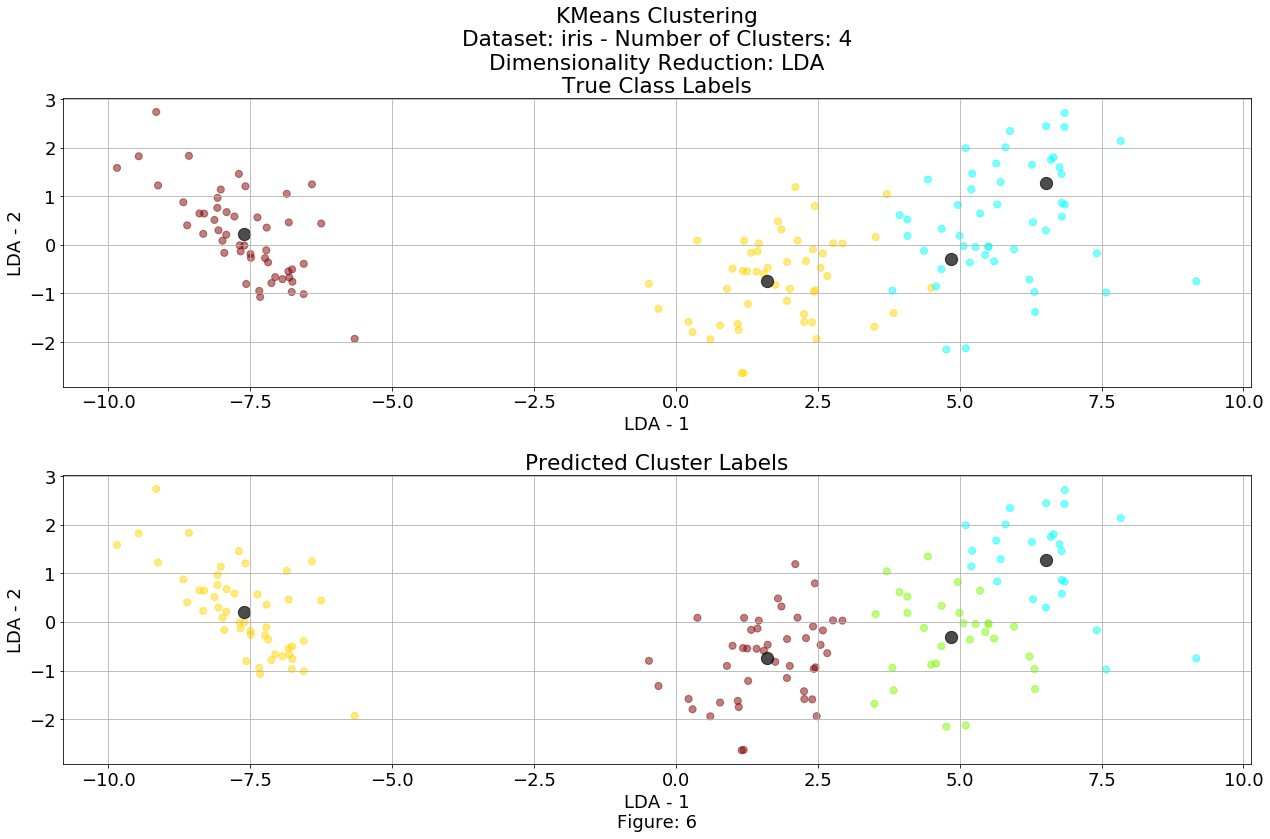

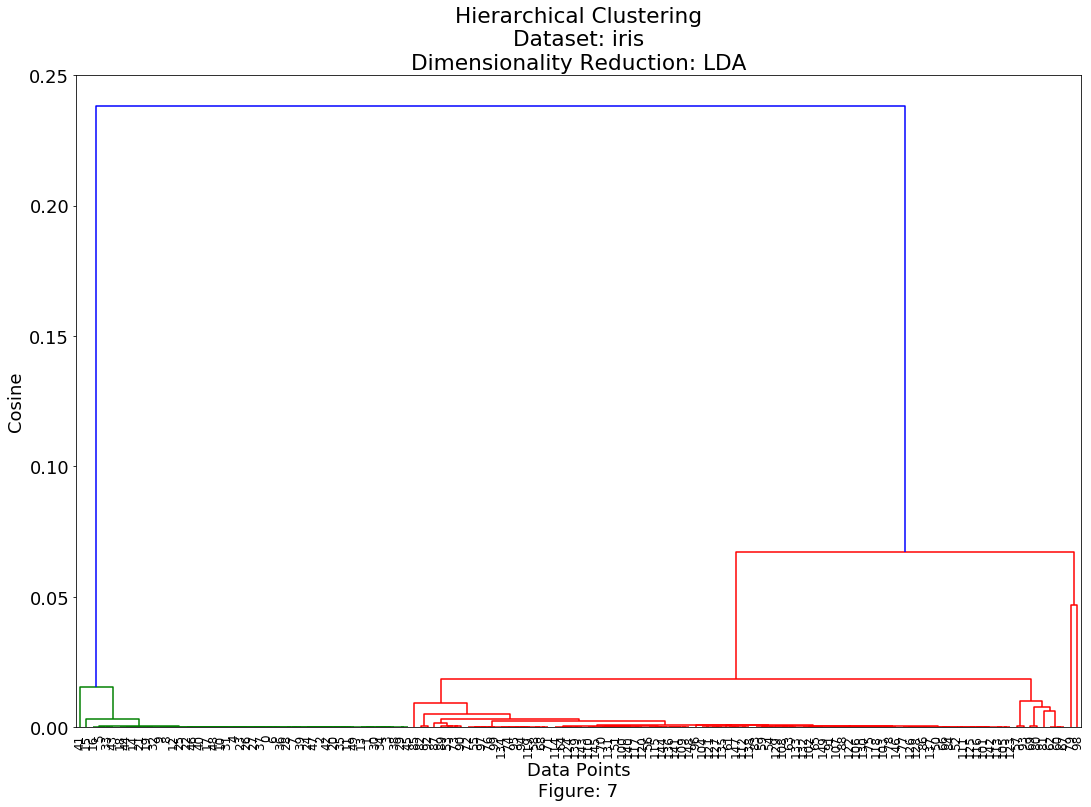

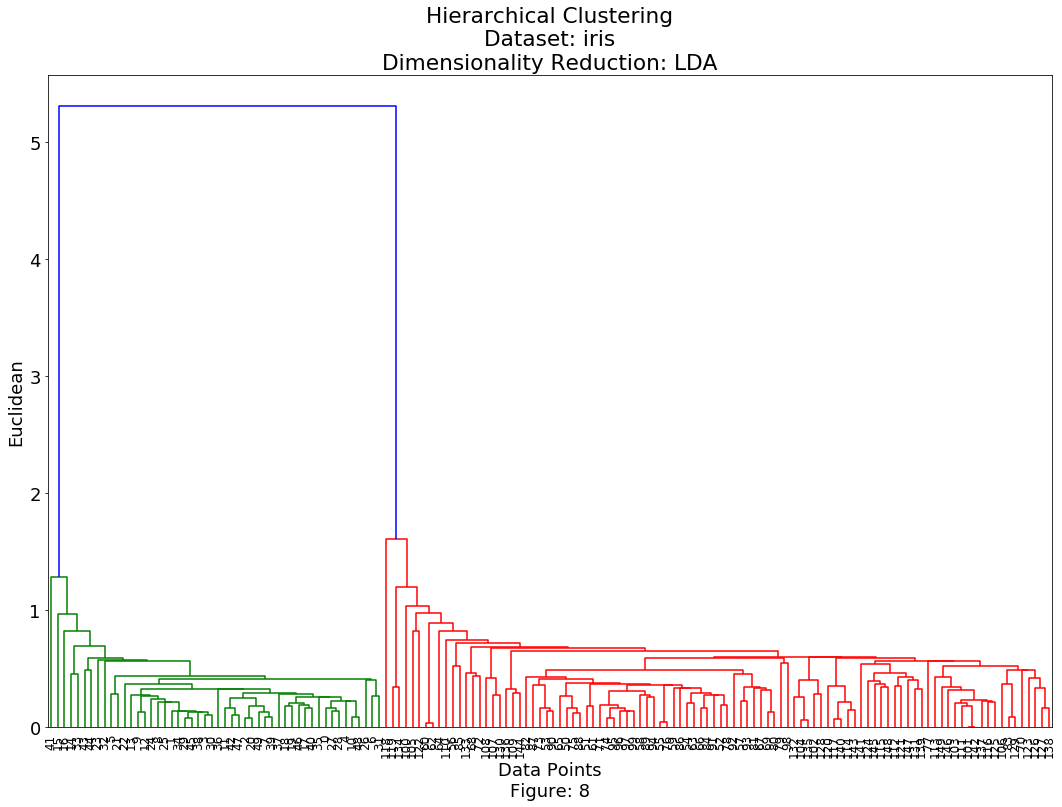

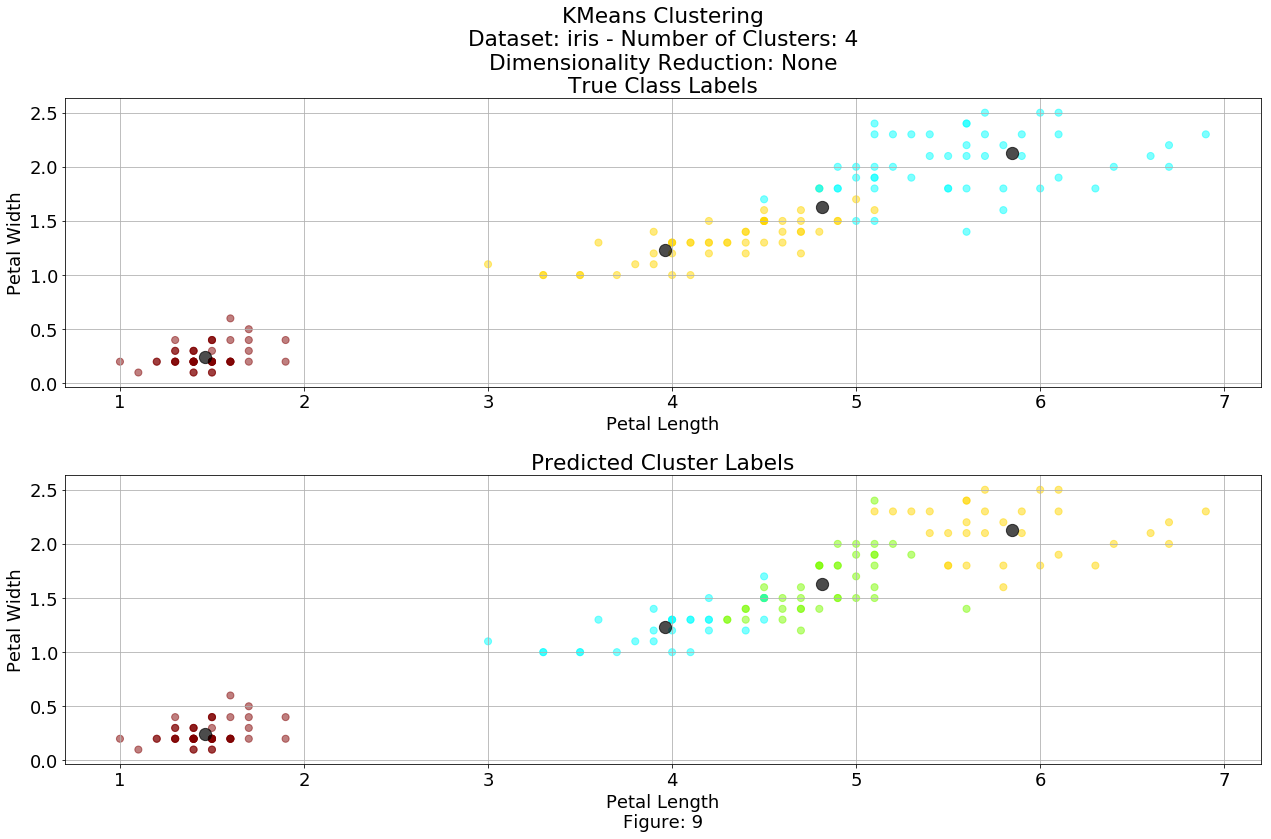

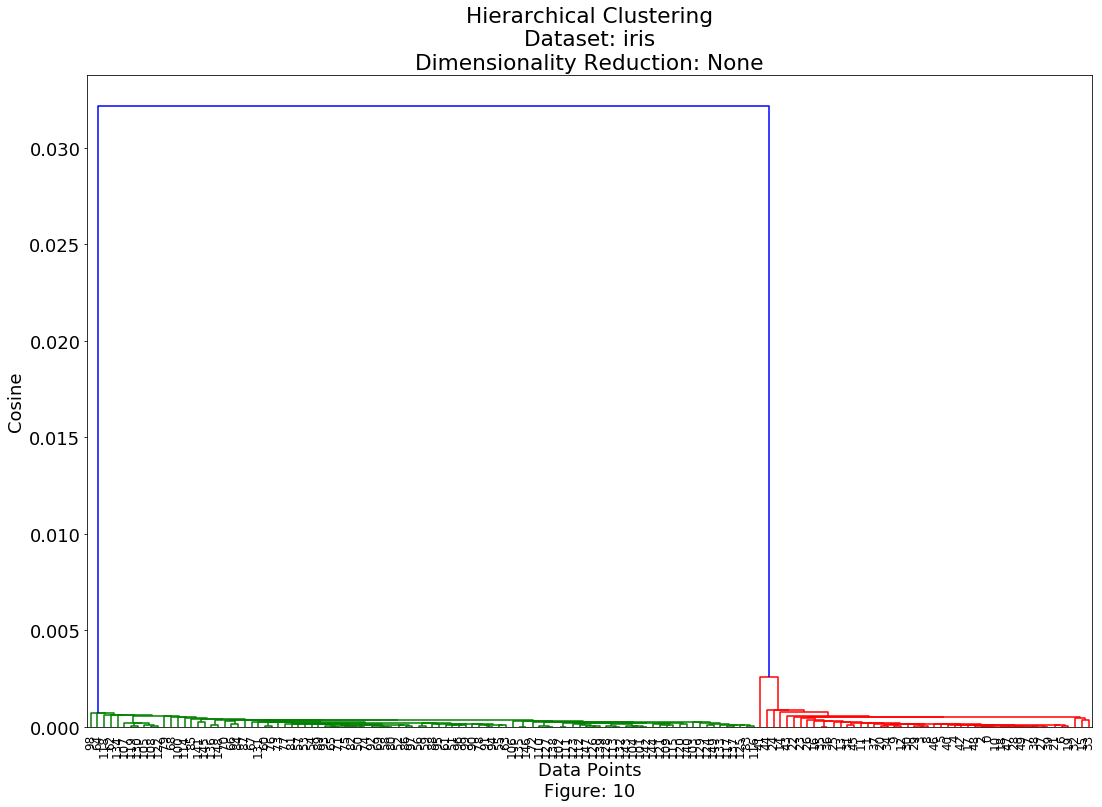

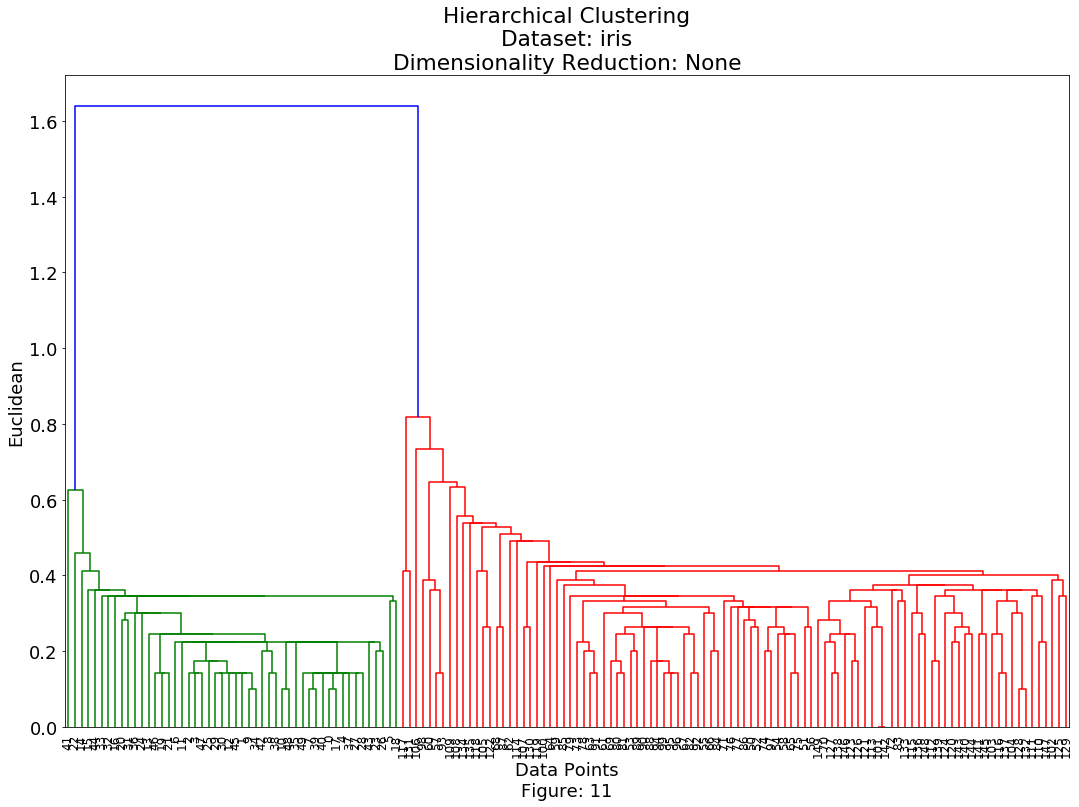

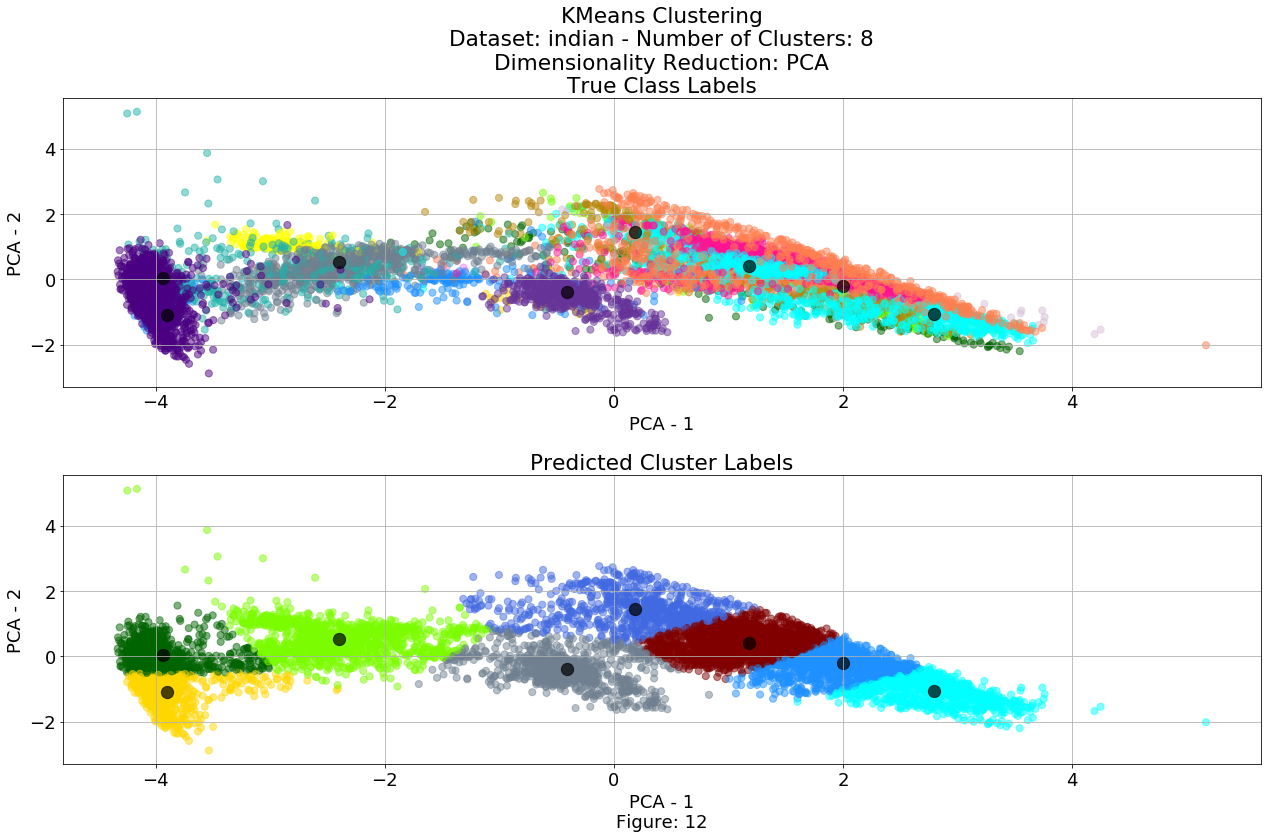

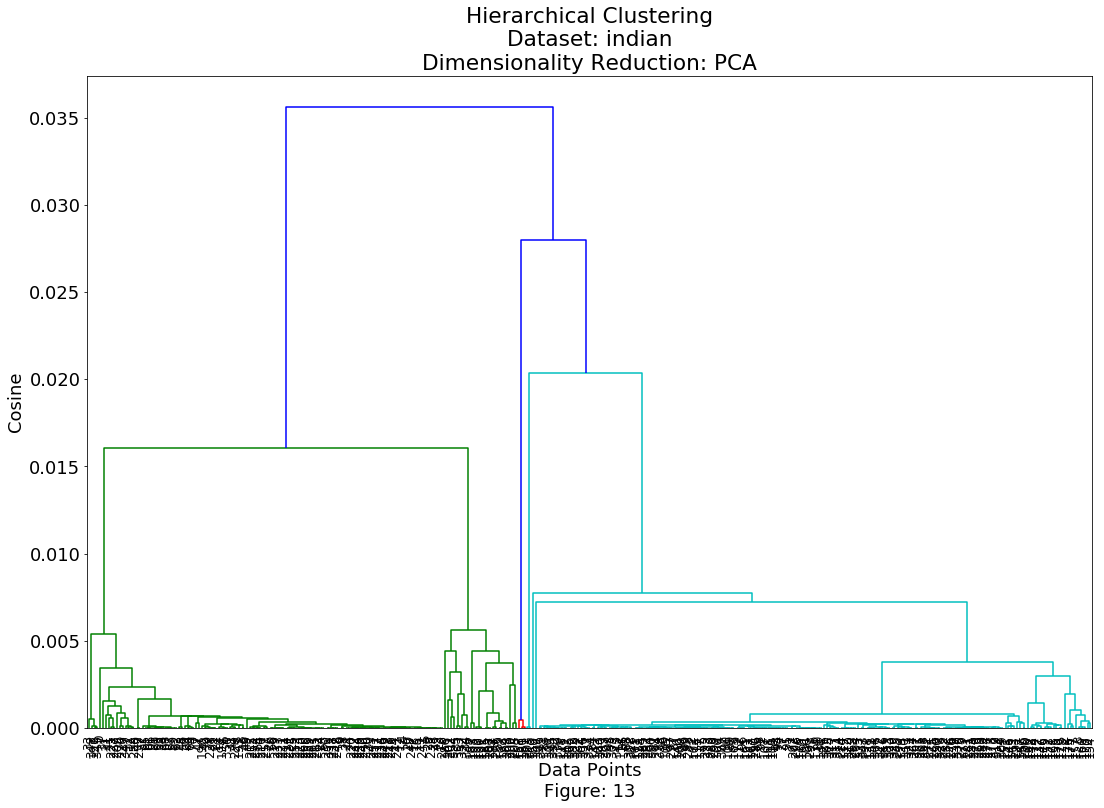

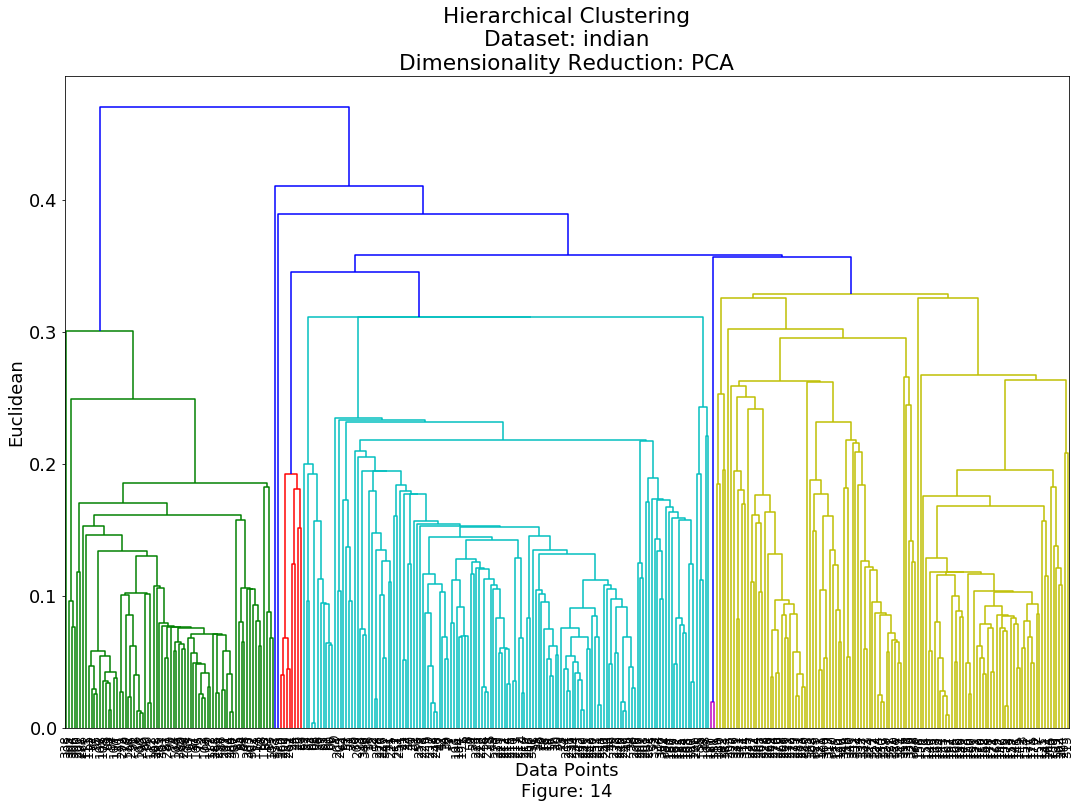

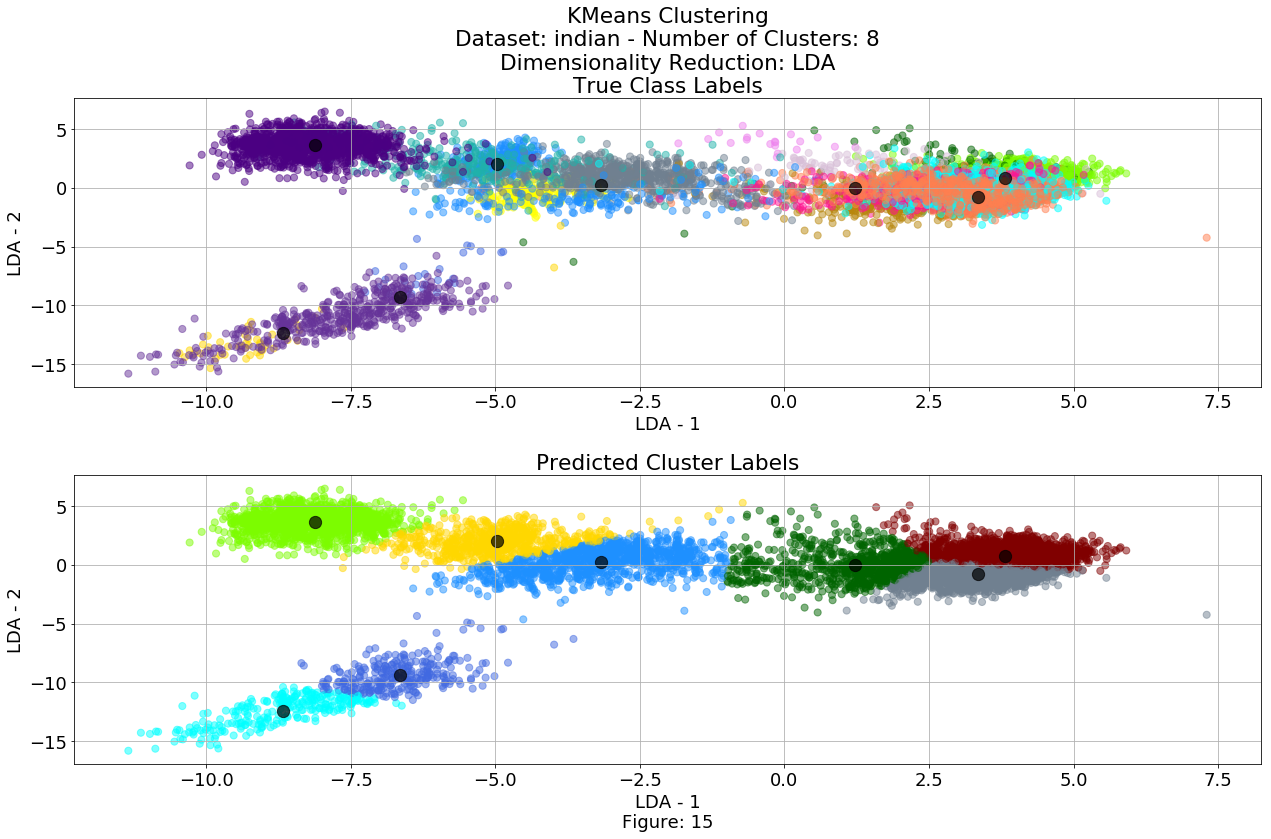

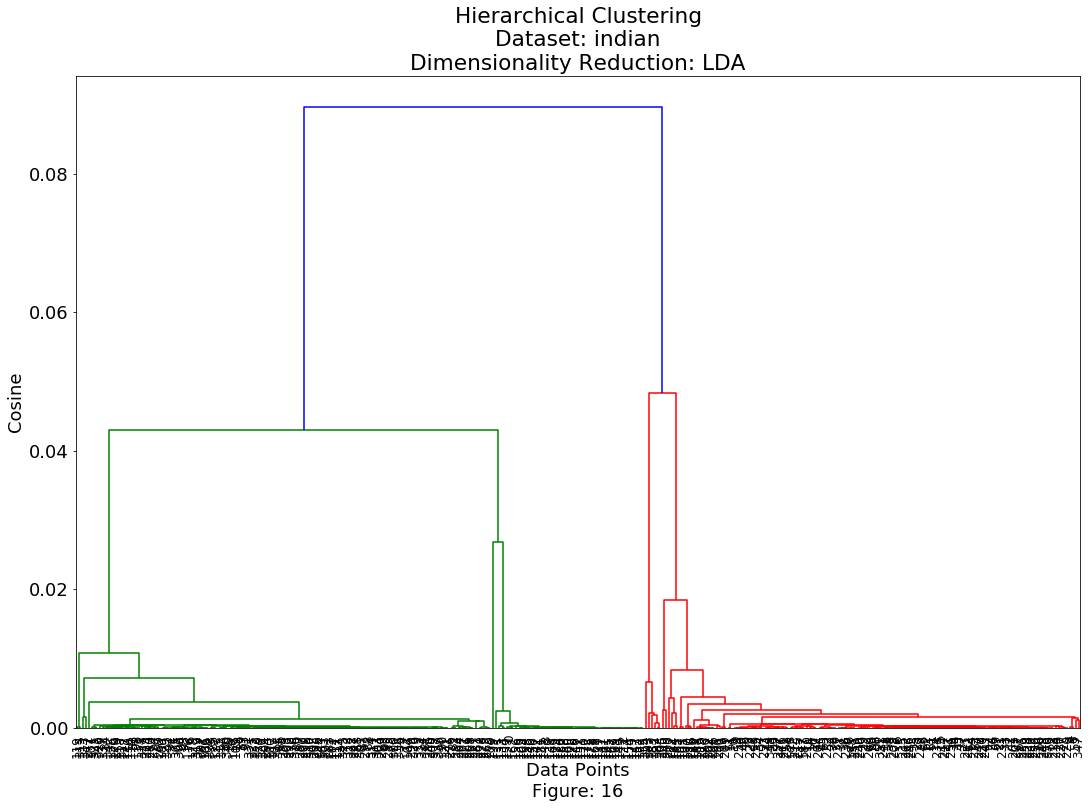

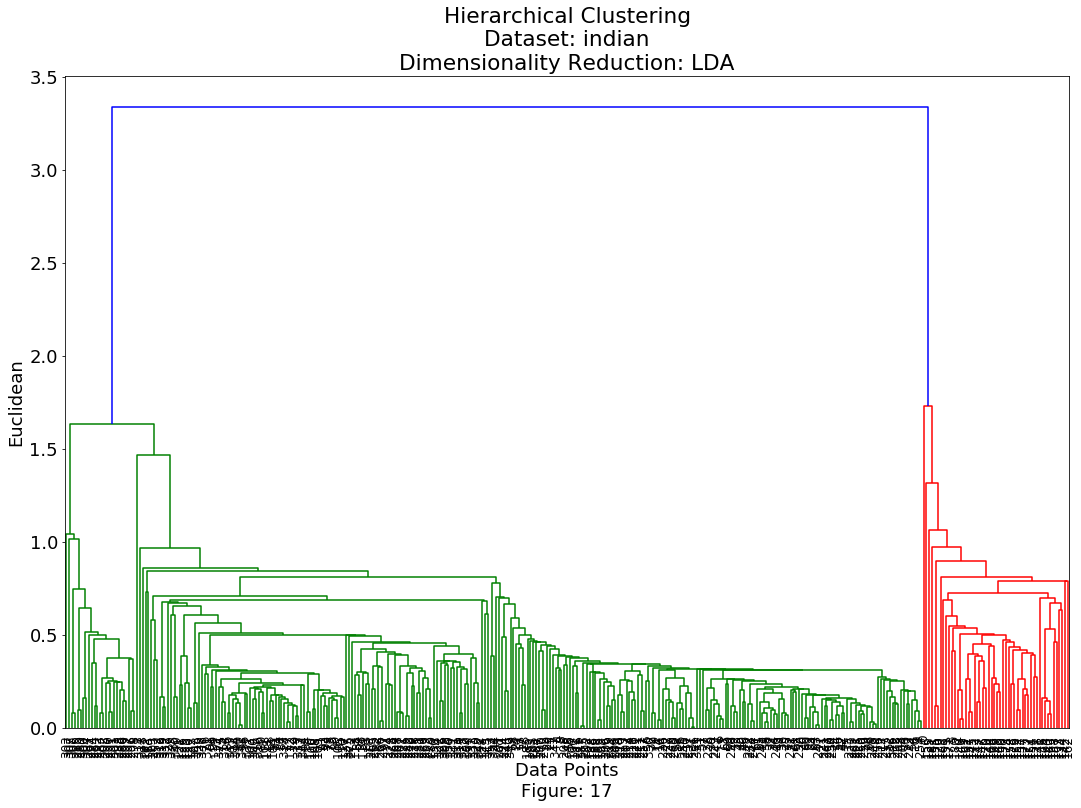

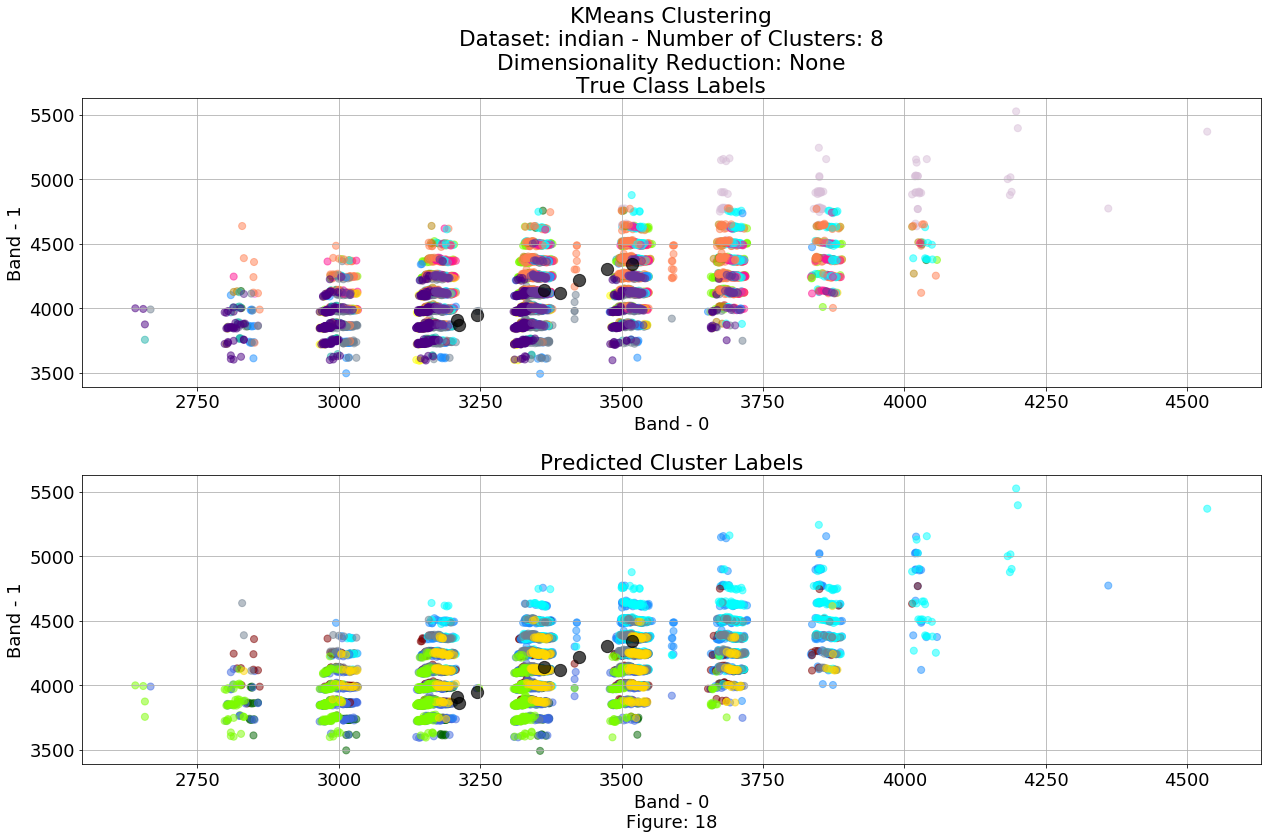

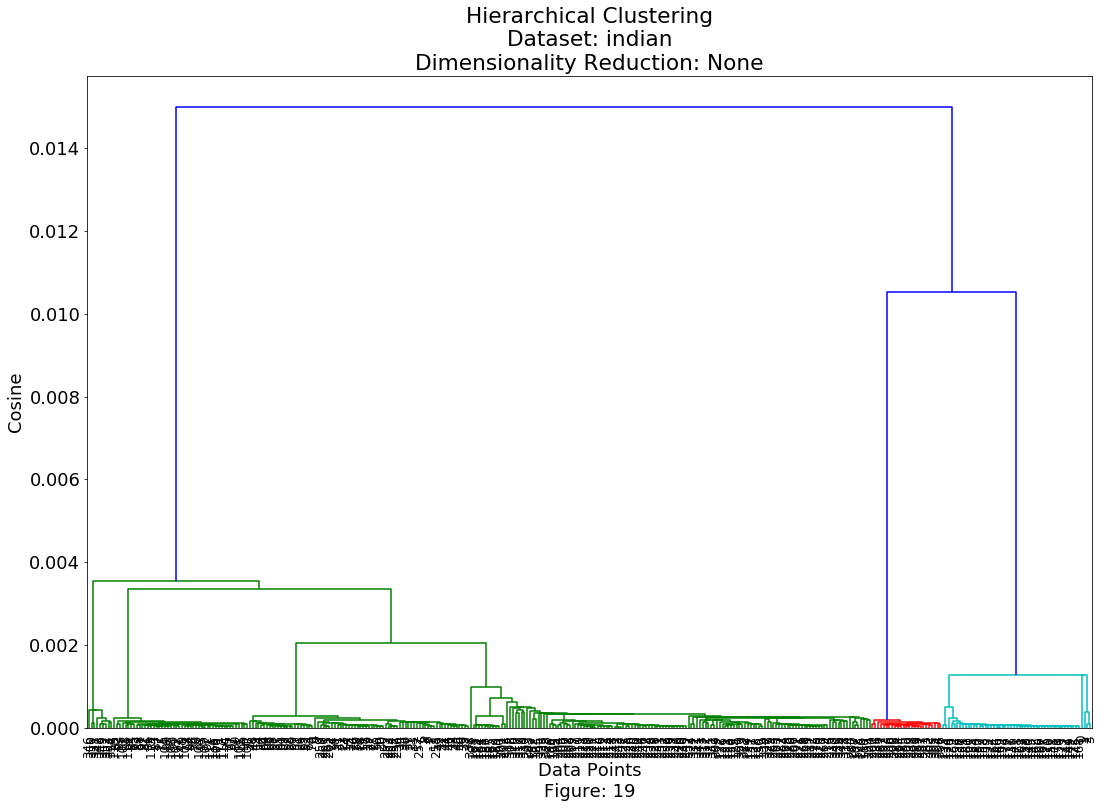

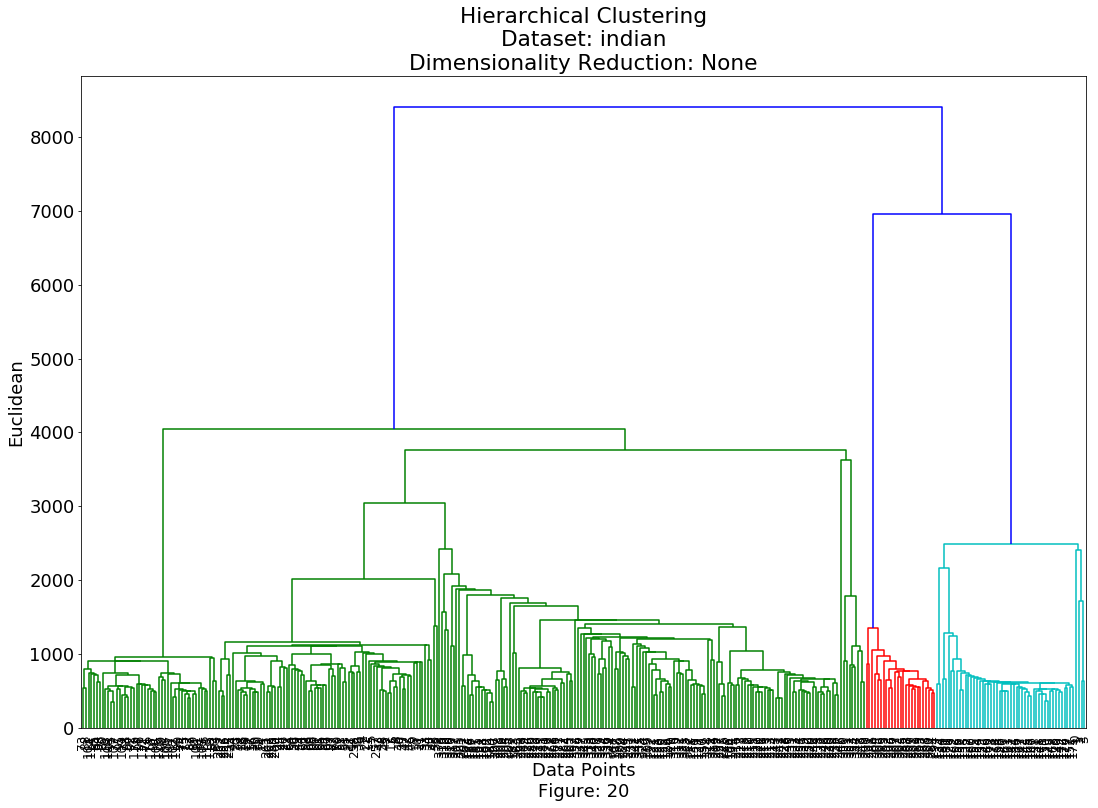

In [22]:
# loop over each dataframe
figure_count = 3
for key, df in dfs.items():
    name, dim_red, dim_num = key.split("_")
    for clusterer in clustering:
        for clust_metric in clustering_metrics:
            # KMeans does not use metric
            if clust_metric == "cosine" and clusterer == "KMeans":
                continue
            # Data too large for dendrogram. Divide data by 10 (by dividing amount of each target by 10)
            # And use that for the hierarchical dendrogram plot
            elif clusterer == "Hierachy" and name == "indian": 
                small_df = smallify_df(df, 10, 50)
                cluster = run_cluster(small_df, num_clusters[name], clusterer, clust_metric)
                plot_cluster(cluster, clusterer, df, name,
                             num_clusters=num_clusters[name], 
                             dim_red=dim_red, metric=clust_metric, figure_count=figure_count)
            else:
                cluster = run_cluster(df, num_clusters[name], clusterer, clust_metric)
                plot_cluster(cluster, clusterer, df, name,
                             num_clusters=num_clusters[name], 
                             dim_red=dim_red, metric=clust_metric, figure_count=figure_count)
            figure_count += 1

Question 3)

a)

In [23]:
def partition_coefficient_score(x, predictions):
    return 1.00000

In [24]:
def print_validity_score(total_table, key):
    score_table = total_table[key]
    name, dim_red, dim_num = key.split("_")
    print(f"==== {name[0].upper()}{name[1:]} - {dim_red} Validity Table ====\n")
    table = []
    line = "S\K "
    for i in range(len(score_table["  DB"])):
        temp = " " + str(i+2)
        temp = temp.ljust(5)
        line += "|" + temp
    table.append(line)
    for index, scores in score_table.items():
        line = index
        for score in scores:
            temp = str(score).ljust(5, "0")
            line += "|" + temp[:5]
        table.append(line)
    output = "\n".join(table)
    print(output)
    print("\n\n")
    return

In [25]:
metrics = {}
iterables = {"indian": range(2,17),
             "iris": range(2,7)}
for key, df in dfs.items():
    name, dim_red, dim_num = key.split("_")
    metrics[key] = {"  DB": [],
                    "SILH": [],
                    " PCI": []}
    x = df.iloc[:, :-1]
    for num_clusters in iterables[name]:
        km = KMeans(n_clusters=num_clusters, max_iter=500, random_state=42, n_jobs=3)
        km.fit(x)
        predictions = km.predict(x)
        metrics[key]["  DB"].append(davies_bouldin_score(x, predictions))
        metrics[key]["SILH"].append(silhouette_score(x, predictions))
        metrics[key][" PCI"].append(partition_coefficient_score(x, predictions))

In [26]:
for key, df in dfs.items():
    print_validity_score(metrics, key)

==== Iris - PCA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   
  DB|0.435|0.609|0.682|0.739|0.789
SILH|0.665|0.565|0.526|0.448|0.429
 PCI|1.000|1.000|1.000|1.000|1.000



==== Iris - LDA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   
  DB|0.296|0.487|0.694|0.828|0.862
SILH|0.768|0.655|0.584|0.453|0.406
 PCI|1.000|1.000|1.000|1.000|1.000



==== Iris - None Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   
  DB|0.404|0.661|0.780|0.805|0.914
SILH|0.681|0.552|0.498|0.488|0.364
 PCI|1.000|1.000|1.000|1.000|1.000



==== Indian - PCA Validity Table ====

S\K | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10  | 11  | 12  | 13  | 14  | 15  | 16  
  DB|0.468|0.740|0.764|0.733|0.703|0.704|0.705|0.753|0.818|0.799|0.778|0.783|0.805|0.811|0.798
SILH|0.666|0.494|0.459|0.468|0.465|0.453|0.435|0.412|0.403|0.410|0.415|0.404|0.380|0.386|0.381
 PCI|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000



==== Indian - LDA Validity Table ====

Based on the validity tables above, we can determine the best number of clusters based on each metric. For Davies Bouldin (DB) we want the lowest value, for Silhouette (SILH) we want the largest value and for Partition Coefficient Index (PCI) we also want the largest value.  

In [27]:
best = [
        ["Iris", "None", 2, 2, 2],
        ["Iris", "PCA", 2, 2, 2],
        ["Iris", "LDA", 2, 2, 2],
        ["Indian", "None", 11, 2, 2],
        ["Indian", "PCA", 2, 2, 2],
        ["Indian", "LDA", 3, 3, 2]
       ]
best_cluster = pd.DataFrame(best)
best_cluster.columns = ["Dataset", "Dim Red", "DB", "SILH", "PCI"]
best_cluster.set_index(["Dataset", "Dim Red"], inplace=True)

print(best_cluster)

                 DB  SILH  PCI
Dataset Dim Red               
Iris    None      2     2    2
        PCA       2     2    2
        LDA       2     2    2
Indian  None     11     2    2
        PCA       2     2    2
        LDA       3     3    2


It is important to note what each index measures to properly understand why it validates the number of clusters that it does.  

The Davies Bouldin metric measures the average case of error of each cluster. It has the inverse ratio of LDA and tries to maximize the cluster separation and minimizes the cluster variance.  

The Silhouette metric measures how similar an object is to its own cluster as compared to its similarity to other clusters.    

The Partition Coefficient metric measures the partitioning for the dataset. Since kmeans is a hard/crisp partitioning method, the partition coefficient will always be 1 as a sample is always 100% in exactly one cluster. Therefore, it provides no useful information for the kmeans clustering method.  

For the iris dataset, it makes no difference which metric or which dimensionality reduction approach we use. The answer is always just 2 clusters. This is because the iris dataset is a simple dataset where there is 2 classes with some overlap and 1 class with a large separation from the other two. So the cluster validation techniques prefer 2 clusters because they are grouping the overlapping clusters as one larger clusters. This demonstrates how DB and SILH are both susceptible to incorrect decisions as they would prefer to group clusters together into one larger, cleaner cluster instead of using more, closer, smaller clusters.   
   
For the indian dataset, the metrics did in fact vary a little with the dimensionality reduction approach used. The only big difference is that without dimensionality reduction, the DB score proposed 11 clusters while the other metrics and dimensionality reductions chose either 2 or 3. The main reason can be seen in figures 12 and 15 as the PCA and LDA techniques with just two components do a good job of separating the classes into 2 or 3 larger clusters, but each larger cluster contains several different classes within. With only 2 components for LDA and PCA, we are not able to distinguish classes exactly, and instead can only distinguish grouping of classes. The data has too much overlap. After the LDA and PCA, we arrive at a similar issue as that with iris. The larger clusters have clear separation, but within these large clusters, the separation between the internal clusters is not so clear. Therefore, these measures prefer the fewer, larger clusters with minimal overlapping to the more, smaller clusters with some overlapping. With all the components still in use, the SILH index still fails but DB actually appears to do fairly well. The reason for 11 clusters with DB is most likely either not enough data for some of the smaller classes to correctly start creating a cluster (for example soybean mill has 2500 samples but oats only has 20) or some of the data has a large amount of overlap. The SILH only expects there to be 2 clusters, but its performance for 2 clusters is roughly the same as its performance for any amount of clusters. It appears from its lack of change in score versus clusters that it is really providing much useful information. For example, its max is 2 clusters with 0.394 while its min is 7 with 0.354. Compare this to LDA where its max is 3 clusters with 0.737 and its min is 16 clusters with a score of 0.353. 

b)

i)  

Dimensionality reduction can help, but can also harm data separability and clustering performance. For example, if we take a sphere where one half is all class A (call this the western hemisphere) and one half is all class B (call this the eastern hemisphere) and we collapse it down to a circle looking through the center of the western/eastern hemispheres, then there is complete overlap between the two. Before, a simple plane would split the two datasets and now it is impossible. The hope is that through PCA/LDA, the collapsing of the dimensions is done in the optimal way to still allow a clear separation of classes (for example if collapsed by making the y axis the plane of separation of the two hemispheres, then the classes are easily and perfectly separable), but we have shown in lectures and homework that LDA/PCA have shortcomings that can prevent this. For example PCA does not consider classes and so may incorrectly reduce dimensions, while LDA has trouble if the means are the same. Another important issue to consider is how cluster validation is performed. A lot of the validation measures use some metric to capture similarity or dissimilarity. Certain metrics lose quality if there are too many dimensions. For example, euclidean distance becomes meaningless as the dimensions expand infinitely since it becomes a sum of many small distances. In this case, reducing dimensions can be quite helpful. Unsupervised learning is a fine balance, and in a real world case where we have no ground truths, it can be challenging to determine cluster performance properly. 

ii)

For the iris dataset, kmeans clustering worked best, but it did not appear to "see" the three clusters that we know exist from the data. The elbow method was inconclusive and 2, 3 or 4 appeared as viable options for number of clusters. The measures used in part a seemed to suggest only 2 clusters as well. However, the limitations of these measures were explained above and different measures would probably be better suited to the problem. Dimensionality reduction played a minimal role in the clustering performance. This is because the iris dataset is trivially small and already well separated so the dimensionality reduction does not provide any extra benefit.

For the indian dataset, kmeans clustering did fairly well for the non-dimensionality reduced data. Reducing the data from about 200 dimensions to 2 for both LDA and PCA causes too much overlapping in the data and is apparent from figures 12 and 15 It is possible that kmeans would perform much better if the dimensions were reduced to say 10 instead of 2. Also, the measures used are susceptible to overlapping clusters and it may be better to use a measure that is more robust. Furthermore, due to overlapping clusters, a fuzzy partitioning may have better performance compared to our crisp kmeans partitioning. It is hard to determine heirarchical clustering performance but the PCA seemed to do the best as it appears to have found about 6 clusters. Note that due to plotting constraints, the hierarchical clustering only worked on a subsample of the data in order to make the plot clearer and easier. The full data may or may not perform even better. I would expect hierarchical to perform better on the reduced dimensionality data as there is overlapping in the clusters and so it may be able to furhter split the larger clusters down to smaller internal clusters in its hierarchy. As seen in figure 14 for the PCA case.